In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import silhouette_score

BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# No Augmentation for Validation Set
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load Dataset
cifar10_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
cifar10_val = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_val)

train_loader = DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify output layer for CIFAR-10 classes
model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [6]:
# Training Loop
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")

In [7]:
# Feature Extraction
def extract_features():
    model.eval()
    features, labels_list = [], []
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())
    model.layer4[-1].register_forward_hook(hook)
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            _ = model(images)  # Forward pass to trigger the hook
            labels_list.extend(labels.numpy())
    
    return np.concatenate(features, axis=0), np.array(labels_list)

In [8]:
# t-SNE Visualization
def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features.reshape(features.shape[0], -1))
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap="jet", alpha=0.5)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of ResNet Features")
    plt.show()

In [9]:
train_model()

Epoch [1/10], Loss: 1.1122
Epoch [2/10], Loss: 0.8213
Epoch [3/10], Loss: 0.7341
Epoch [4/10], Loss: 0.6695
Epoch [5/10], Loss: 0.6271
Epoch [6/10], Loss: 0.6088
Epoch [7/10], Loss: 0.5727
Epoch [8/10], Loss: 0.5442
Epoch [9/10], Loss: 0.5287
Epoch [10/10], Loss: 0.5040


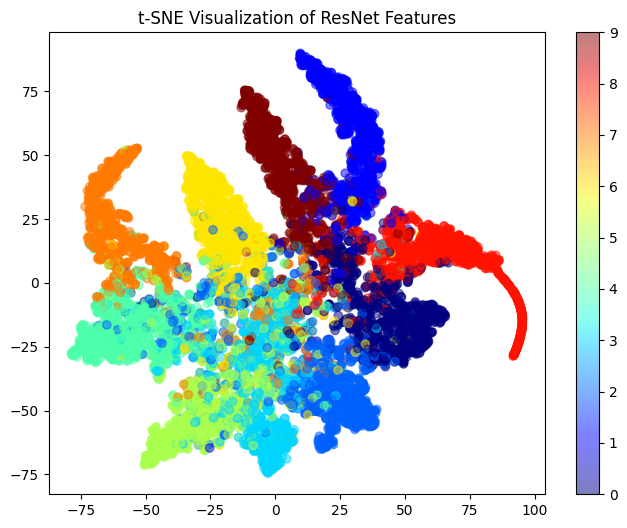

In [10]:
features, labels = extract_features()
visualize_tsne(features, labels)

In [12]:
# Feature Extraction
def extract_features(dataloader):
    model.eval()
    features, labels_list = [], []
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())
    model.layer4[-1].register_forward_hook(hook)
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            _ = model(images)  # Forward pass to trigger the hook
            labels_list.extend(labels.numpy())
    
    return np.concatenate(features, axis=0), np.array(labels_list)

# t-SNE Visualization with Silhouette Score
def visualize_tsne(train_features, val_features):
    all_features = np.vstack((train_features, val_features))
    labels = np.array([0] * len(train_features) + [1] * len(val_features))  # 0 for train, 1 for val
    
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(all_features.reshape(all_features.shape[0], -1))
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap="coolwarm", alpha=0.5)
    plt.colorbar(scatter, ticks=[0, 1], label="Dataset (0: Train, 1: Validation)")
    plt.title("t-SNE Visualization of ResNet Features")
    plt.show()
    
    score = silhouette_score(all_features.reshape(all_features.shape[0], -1), labels)
    print(f"Silhouette Score: {score:.4f}")

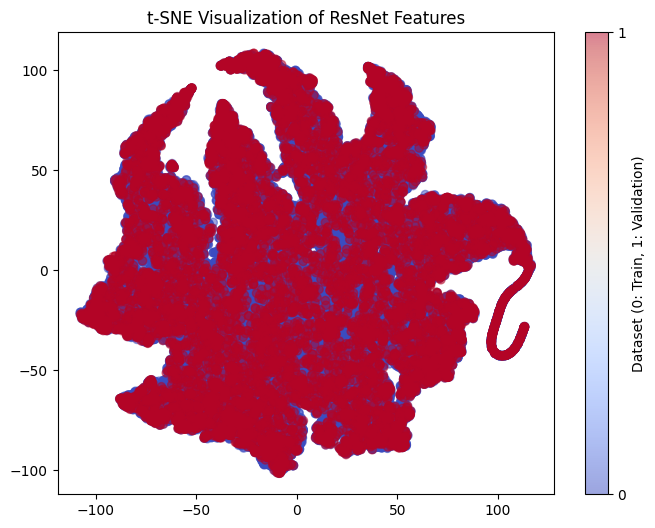

Silhouette Score: 0.1149


In [13]:
train_features, _ = extract_features(train_loader)
val_features, _ = extract_features(val_loader)
visualize_tsne(train_features, val_features)